## MSFT Financial data import from YF

In [21]:
# basic
import yfinance as yf
import pandas as pd
import numpy as np
import warnings
import math

# visualization
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# timeseries
# dart
import torch
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import NBEATSModel
# RF model test with Covariate
from darts.models import RandomForest
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# darts model evaluation
from darts.metrics import mape, mase


In [22]:
mcsf = yf.Ticker("MSFT")

# mcsf.financials, mcsf.balancesheet, and mcsf.cashflow
fn_df = mcsf.financials
bl_df = mcsf.balancesheet
cf_df = mcsf.cashflow

In [23]:
fn_df.head()

,2023-06-30,2022-06-30,2021-06-30,2020-06-30
Tax Effect Of Unusual Items,-2850000.0,43420000.0,180160797.164637,4760000.0
Tax Rate For Calcs,0.19,0.13,0.138266,0.17
Normalized EBITDA,105155000000.0,99905000000.0,83831000000.0,68395000000.0
Total Unusual Items,-15000000.0,334000000.0,1303000000.0,28000000.0
Total Unusual Items Excluding Goodwill,-15000000.0,334000000.0,1303000000.0,28000000.0


In [24]:
# the number of each df are 73, 54, 47.
transposed_fn_df = fn_df.transpose() 
transposed_bl_df = bl_df.transpose()
transposed_cf_df = cf_df.transpose()
transposed_fn_df.head()

,Tax Effect Of Unusual Items,Tax Rate For Calcs,Normalized EBITDA,Total Unusual Items,Total Unusual Items Excluding Goodwill,Net Income From Continuing Operation Net Minority Interest,Reconciled Depreciation,Reconciled Cost Of Revenue,EBITDA,EBIT,...,Operating Expense,Research And Development,Selling General And Administration,Selling And Marketing Expense,General And Administrative Expense,Other Gand A,Gross Profit,Cost Of Revenue,Total Revenue,Operating Revenue
2023-06-30,-2850000.0,0.19,105155000000.0,-15000000.0,-15000000.0,72361000000.0,13861000000.0,65863000000.0,105140000000.0,91279000000.0,...,57529000000.0,27195000000.0,30334000000.0,22759000000.0,7575000000.0,7575000000.0,146052000000.0,65863000000.0,211915000000.0,211915000000.0
2022-06-30,43420000.0,0.13,99905000000.0,334000000.0,334000000.0,72738000000.0,14460000000.0,62650000000.0,100239000000.0,85779000000.0,...,52237000000.0,24512000000.0,27725000000.0,21825000000.0,5900000000.0,5900000000.0,135620000000.0,62650000000.0,198270000000.0,198270000000.0
2021-06-30,180160797.164637,0.138266,83831000000.0,1303000000.0,1303000000.0,61271000000.0,11686000000.0,52232000000.0,85134000000.0,73448000000.0,...,45940000000.0,20716000000.0,25224000000.0,20117000000.0,5107000000.0,5107000000.0,115856000000.0,52232000000.0,168088000000.0,168088000000.0
2020-06-30,4760000.0,0.17,68395000000.0,28000000.0,28000000.0,44281000000.0,12796000000.0,46078000000.0,68423000000.0,55627000000.0,...,43978000000.0,19269000000.0,24709000000.0,19598000000.0,5111000000.0,5111000000.0,96937000000.0,46078000000.0,143015000000.0,143015000000.0


### Select the number of the financial variables

there are many financial data elements. but I do not use everything.
because too many variables can happen overfitting, complication of calculation, hard interpret problems.
so I try to find the number of proper finance varibles. for this, I try to find out feature importance through random forest, Gradient Boosting as regressor model.

#### second, download the financial indicator!
1. decide what stock I analyze.
from yahoo finance site, I import the data that satisfy the market capital above 10,000,000 and region is US. the amount of the stock is 204.
2. 
. use key financial ratio.
- P/E: price-to-earnings ratio
- P/B: price-to-book ratio
- debt-to-equity ratio
- ROE: return on equity

In [25]:
# import the data from yh_my_stock(save the stock that satisfied market capitalization over 1000.000B) 
df = pd.read_excel("Fn_IC.xlsx", skiprows=1)
df.head()

,Symbol,EPS (TTM),Trailing P/E,Forward P/E,EBITDA,Price/Book,Price/Sales,Book Val,Last Price,Volume,Company Name,Div/Share,Market Cap
0,BRK-A,"52,674.49",11.27,22.37,109.876B,1.63,2.45,"363,303.28","593,850.00","10,755",Berkshire Hathaway Inc.,-,856.082B
1,BKNG,141.32,26.52,21.19,6.83B,-210.99,6.34,-17.76,"3,747.61","256,668",Booking Holdings Inc.,-,130.754B
2,HESAF,44.18,51.55,-,6.421B,15.70,18.41,145.07,"2,277.41",122,Hermès International Société en commandite par...,13.00,247.145B
3,CHDRF,39.50,21.46,-,26.691B,7.10,1.78,119.32,847.70,70,Christian Dior SE,12.00,153.113B
4,BLK,36.49,21.32,17.09,6.76B,3.00,6.47,259.34,778.07,"625,587","BlackRock, Inc.",20.00,115.543B


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Symbol        204 non-null    object
 1   EPS (TTM)     204 non-null    object
 2   Trailing P/E  204 non-null    object
 3   Forward P/E   204 non-null    object
 4   EBITDA        204 non-null    object
 5   Price/Book    204 non-null    object
 6   Price/Sales   204 non-null    object
 7   Book Val      204 non-null    object
 8   Last Price    204 non-null    object
 9   Volume        204 non-null    object
 10  Company Name  204 non-null    object
 11  Div/Share     204 non-null    object
 12  Market Cap    204 non-null    object
dtypes: object(13)
memory usage: 20.8+ KB


In [8]:
# data cleaning
# col[EBITDA]'s M,B,T value chage to numeric
# data type from str to int or float

def convert_column_value(value):
    try:
        if 'T' in value:
            number_part = value.replace('T', '')
            return float(number_part) * 1_000_000_000_000  # 1T = 1,000,000,000,000
        if 'B' in value:
            number_part = value.replace('B', '')
            return float(number_part) * 1_000_000_000  # 1B = 1,000,000,000
        if 'M' in value:
            number_part = value.replace('M', '')
            return float(number_part) * 1_000_000  # 1M = 1,000,000
        else:
            return float(value)
    except ValueError:
        return value  # just return when the value is not number.

# EBITDA column apply new value.
df["EBITDA"] = df["EBITDA"].apply(convert_column_value)

print(df)

    Symbol  EPS (TTM) Trailing P/E Forward P/E           EBITDA Price/Book  \
0    BRK-A  52,674.49        11.27       22.37   109876000000.0       1.63   
1     BKNG     141.32        26.52       21.19     6830000000.0    -210.99   
2    HESAF      44.18        51.55           -     6421000000.0      15.70   
3    CHDRF      39.50        21.46           -    26691000000.0       7.10   
4      BLK      36.49        21.32       17.09     6760000000.0       3.00   
..     ...        ...          ...         ...              ...        ...   
199  NPPXF     0.0900        13.56           -  3400000000000.0       0.01   
200    ARM       0.08     1,499.75       79.46      244500000.0      24.65   
201  RLLCF     0.0180         0.26           -     1712000000.0      -0.01   
202  GDVTZ          -            -           -                -          -   
203     BA      -3.66            -       26.08     3154000000.0      -7.23   

    Price/Sales    Book Val  Last Price   Volume  \
0          

In [9]:
# Remove commas from the DataFrame
df = df.applymap(lambda x: str(x).replace(',', '') if isinstance(x, str) else x)

In [11]:
# Replace non-numeric values with NaN and then convert to float
df['EPS (TTM)'] = pd.to_numeric(df['EPS (TTM)'], errors='coerce')
df['Trailing P/E'] = pd.to_numeric(df['Trailing P/E'], errors='coerce')
df['Forward P/E'] = pd.to_numeric(df['Forward P/E'], errors='coerce')
df['EBITDA'] = pd.to_numeric(df['EBITDA'], errors='coerce')
df['Price/Book'] = pd.to_numeric(df['Price/Book'], errors='coerce')
df['Price/Sales'] = pd.to_numeric(df['Price/Sales'], errors='coerce')
df['Book Val'] = pd.to_numeric(df['Book Val'], errors='coerce')
df['Div/Share'] = pd.to_numeric(df['Div/Share'], errors='coerce')
df['Last Price'] = pd.to_numeric(df['Last Price'], errors='coerce')

# Convert the column to float
df['EPS (TTM)'] = df['EPS (TTM)'].astype(float)
df['Trailing P/E'] = df['Trailing P/E'].astype(float)
df['Forward P/E'] = df['Forward P/E'].astype(float)
df['EBITDA'] = df['EBITDA'].astype(float)
df['Price/Book'] = df['Price/Book'].astype(float)
df['Price/Sales'] = df['Price/Sales'].astype(float)
df['Book Val'] = df['Book Val'].astype(float)
df['Div/Share'] = df['Div/Share'].astype(float)
df['Last Price'] = pd.to_numeric(df['Last Price'], errors='coerce')

In [12]:
# some stock has nan data, because some company has not the information, so I choose the company has nan value remove the data.
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108 entries, 4 to 195
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Symbol        108 non-null    object 
 1   EPS (TTM)     108 non-null    float64
 2   Trailing P/E  108 non-null    float64
 3   Forward P/E   108 non-null    float64
 4   EBITDA        108 non-null    float64
 5   Price/Book    108 non-null    float64
 6   Price/Sales   108 non-null    float64
 7   Book Val      108 non-null    float64
 8   Last Price    108 non-null    float64
 9   Volume        108 non-null    object 
 10  Company Name  108 non-null    object 
 11  Div/Share     108 non-null    float64
 12  Market Cap    108 non-null    object 
dtypes: float64(9), object(4)
memory usage: 11.8+ KB


In [13]:
# split the data X and y
X =df.drop(['Last Price','Symbol','Company Name','Market Cap','Volume'],axis =1)
y =df['Last Price']
print(X.shape, y.shape)

(108, 8) (108,)


In [14]:
# train and test data split //I think it does not necessary to split the train and test data.
X_train , X_test , y_train ,y_test = train_test_split(X , y, test_size=0.2 , random_state= 52)
print(X_train.shape)

(86, 8)


In [15]:
# scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### model select&fit&evaluation

In [16]:
# model definition : SVR, RandomForest, GradientBoost
svr = SVR(kernel='rbf')
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)

In [17]:
# model training
svr.fit(X_train_scaled, y_train)
rf_regressor.fit(X_train_scaled, y_train)
gb_model.fit(X_train_scaled, y_train)

# model prediction
svr_y_pred = svr.predict(X_test_scaled)
rf_y_pred = rf_regressor.predict(X_test_scaled)
gb_y_pred = gb_model.predict(X_test_scaled)

# model evaluation_mse
svr_mse = mean_squared_error(y_test, svr_y_pred)
rf_mse = mean_squared_error(y_test, rf_y_pred)
gb_mse = mean_squared_error(y_test, gb_y_pred)

print("SVR Mean Squared Error:", svr_mse)
print("Random Forest Mean Squared Error:", rf_mse)
print("GradientBoosting Mean Squared Error:", gb_mse)

# model evaluation_R2
svr_r2 = r2_score(y_test, svr_y_pred)
rf_r2 = r2_score(y_test, rf_y_pred)
gb_r2 = r2_score(y_test, gb_y_pred)

print("SVR r2:", svr_r2)
print("Random Forest r2:", rf_r2)
print("GradientBoosting r2:", gb_r2)

SVR Mean Squared Error: 87765.41430318452
Random Forest Mean Squared Error: 19341.32407088687
GradientBoosting Mean Squared Error: 13416.16530474794
SVR r2: -0.2658686062039213
Random Forest r2: 0.7210339045495335
GradientBoosting r2: 0.806494362161218


In [18]:
from sklearn.inspection import permutation_importance

# Permutation Importance_SVR
result = permutation_importance(svr, X_train_scaled, y_train, n_repeats=100, random_state=42)
feature_importance_svr = result.importances_mean
print("SVR Feature Importance:\n", feature_importance_svr)

# Permutation Importance_RF
result = permutation_importance(rf_regressor, X_train_scaled, y_train, n_repeats=100, random_state=42)
feature_importance_rf = result.importances_mean
print("RF Feature Importance:\n", feature_importance_rf)

# Permutation Importance_GB
result = permutation_importance(gb_model, X_train_scaled, y_train, n_repeats=100, random_state=42)
feature_importance_gb = result.importances_mean
print("GB Feature Importance:\n", feature_importance_gb)

SVR Feature Importance:
 [0.03514924 0.00063609 0.00188981 0.00107498 0.00099203 0.00821437
 0.00106517 0.00117532]
RF Feature Importance:
 [0.97767273 0.1278225  0.09296136 0.02282127 0.03144548 0.03468167
 0.00822809 0.00880554]
GB Feature Importance:
 [1.07705297 0.15662077 0.05923084 0.00308604 0.00109464 0.1017322
 0.00155603 0.00689015]


In [19]:
df_features = pd.DataFrame({
    'Feature': ['EPS', 'Trailing P/E', 'Forward P/E', 'EBITDA', 'Price/Book', 'Price/Sales', 'Book Val','Div/Share'],
    'SVR_Importance': feature_importance_svr,
    'RF_Importance': feature_importance_rf,
    'GB_Importance': feature_importance_gb
})
df_features.set_index('Feature', inplace=True)
df_features

,SVR_Importance,RF_Importance,GB_Importance
Feature,,,
EPS,0.035149,0.977673,1.077053
Trailing P/E,0.000636,0.127823,0.156621
Forward P/E,0.001890,0.092961,0.059231
EBITDA,0.001075,0.022821,0.003086
Price/Book,0.000992,0.031445,0.001095
Price/Sales,0.008214,0.034682,0.101732
Book Val,0.001065,0.008228,0.001556
Div/Share,0.001175,0.008806,0.006890


In [20]:
X_train.head()
# important variables that affects stock price are EPS, Trailing P/E, Price/Sales.

,EPS (TTM),Trailing P/E,Forward P/E,EBITDA,Price/Book,Price/Sales,Book Val,Div/Share
173,1.78,23.71,21.42,7.500000e+09,7.57,3.74,5.58,0.80
155,2.69,44.61,30.45,1.098130e+11,5.02,2.31,23.90,7.05
149,2.78,13.23,13.99,1.502270e+11,0.45,0.58,81.31,2.16
24,15.59,22.94,22.91,2.547200e+10,249.02,2.32,1.44,8.17
170,1.97,8.58,7.35,4.183700e+10,1.17,0.99,14.45,1.11


##### The result of above code we find out what variables is the most important!
I will use basic eps in the above income statement, and P/E and P/S calculate using EPS, Stock price and total revenue. 

* P/E = price / EPS
* P/S = Price / Total revenue


## Model Prediction

### Data preparation for model prediction

In [26]:
# data add Price and Sales data.
msft = yf.Ticker("MSFT")
historical_data = msft.history(start="2019-07-01")
# df.index = df.index.tz_convert(None)
# historical_data.reset_index(inplace=True)
historical_data.index = historical_data.index.tz_convert(None)
# historical_data['Date'] = historical_data.index
historical_data.reset_index(inplace=True)
historical_data.head()
historical_data.info()
h_df = historical_data[['Date', 'Close', 'Volume']]
h_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1189 entries, 0 to 1188
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          1189 non-null   datetime64[ns]
 1   Open          1189 non-null   float64       
 2   High          1189 non-null   float64       
 3   Low           1189 non-null   float64       
 4   Close         1189 non-null   float64       
 5   Volume        1189 non-null   int64         
 6   Dividends     1189 non-null   float64       
 7   Stock Splits  1189 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 74.4 KB


,Date,Close,Volume
0,2019-07-01 04:00:00,129.630814,22613500
1,2019-07-02 04:00:00,130.490707,15237800
2,2019-07-03 04:00:00,131.331497,13629300
3,2019-07-05 04:00:00,130.949310,18141100
4,2019-07-08 04:00:00,130.853821,16779700


In [27]:
# h_df = historical_data[['Date', 'Close', 'Volume']]
h_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1189 entries, 0 to 1188
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1189 non-null   datetime64[ns]
 1   Close   1189 non-null   float64       
 2   Volume  1189 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 28.0 KB


In [28]:
# create a list of our conditions
conditions = [
    (h_df['Date'] < '2020-07-01 04:00:00'),
    (h_df['Date'] >= '2020-07-01 04:00:00') & (h_df['Date'] < '2021-07-01 04:00:00'),
    (h_df['Date'] >= '2021-07-01 04:00:00') & (h_df['Date'] < '2022-07-01 04:00:00'),
    (h_df['Date'] >= '2022-07-01 04:00:00') & (h_df['Date'] < '2023-07-01 04:00:00'),
    (h_df['Date'] >= '2023-07-01 04:00:00') 
    ]

# create a list of the values we want to assign for each condition
values = [5.82, 8.12, 9.70, 9.72, 10.37] # 10.37 is TTM

# create a new column and use np.select to assign values to it using our lists as arguments
h_df['EPS'] = np.select(conditions, values)


C:\Users\dicod\AppData\Local\Temp\ipykernel_20848\633519474.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h_df['EPS'] = np.select(conditions, values)


In [29]:
h_df.head()

,Date,Close,Volume,EPS
0,2019-07-01 04:00:00,129.630814,22613500,5.82
1,2019-07-02 04:00:00,130.490707,15237800,5.82
2,2019-07-03 04:00:00,131.331497,13629300,5.82
3,2019-07-05 04:00:00,130.949310,18141100,5.82
4,2019-07-08 04:00:00,130.853821,16779700,5.82


In [30]:
# according to the condition, add the values.

# create a list of our conditions
conditions = [
    (h_df['Date'] < '2020-07-01 04:00:00'),
    (h_df['Date'] >= '2020-07-01 04:00:00') & (h_df['Date'] < '2021-07-01 04:00:00'),
    (h_df['Date'] >= '2021-07-01 04:00:00') & (h_df['Date'] < '2022-07-01 04:00:00'),
    (h_df['Date'] >= '2022-07-01 04:00:00') & (h_df['Date'] < '2023-07-01 04:00:00'),
    (h_df['Date'] >= '2023-07-01 04:00:00') 
    ]

# create a list of the values we want to assign for each condition
values = [143015000000.0, 168088000000.0, 198270000000.0, 211915000000.0, 227583000] # 227583000 is TTM.

# create a new column
h_df['Total Revenue'] = np.select(conditions, values)

C:\Users\dicod\AppData\Local\Temp\ipykernel_20848\25685695.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h_df['Total Revenue'] = np.select(conditions, values)


In [31]:
h_df.head()

,Date,Close,Volume,EPS,Total Revenue
0,2019-07-01 04:00:00,129.630814,22613500,5.82,1.430150e+11
1,2019-07-02 04:00:00,130.490707,15237800,5.82,1.430150e+11
2,2019-07-03 04:00:00,131.331497,13629300,5.82,1.430150e+11
3,2019-07-05 04:00:00,130.949310,18141100,5.82,1.430150e+11
4,2019-07-08 04:00:00,130.853821,16779700,5.82,1.430150e+11


In [32]:
h_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1189 entries, 0 to 1188
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           1189 non-null   datetime64[ns]
 1   Close          1189 non-null   float64       
 2   Volume         1189 non-null   int64         
 3   EPS            1189 non-null   float64       
 4   Total Revenue  1189 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 46.6 KB


In [33]:
# create financial data EPS, P/E, P/S
# the df dataframe is our final dataframe to use for prediction. 
h_df.loc[:,'P/E'] = h_df['Close']/h_df['EPS']
h_df.loc[:,'P/S'] = h_df['Close']/h_df['Total Revenue']


C:\Users\dicod\AppData\Local\Temp\ipykernel_20848\3343628854.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h_df.loc[:,'P/E'] = h_df['Close']/h_df['EPS']
C:\Users\dicod\AppData\Local\Temp\ipykernel_20848\3343628854.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h_df.loc[:,'P/S'] = h_df['Close']/h_df['Total Revenue']


In [34]:
h_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1189 entries, 0 to 1188
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           1189 non-null   datetime64[ns]
 1   Close          1189 non-null   float64       
 2   Volume         1189 non-null   int64         
 3   EPS            1189 non-null   float64       
 4   Total Revenue  1189 non-null   float64       
 5   P/E            1189 non-null   float64       
 6   P/S            1189 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 65.2 KB


In [35]:
h_df.head()

,Date,Close,Volume,EPS,Total Revenue,P/E,P/S
0,2019-07-01 04:00:00,129.630814,22613500,5.82,1.430150e+11,22.273336,9.064141e-10
1,2019-07-02 04:00:00,130.490707,15237800,5.82,1.430150e+11,22.421084,9.124267e-10
2,2019-07-03 04:00:00,131.331497,13629300,5.82,1.430150e+11,22.565549,9.183058e-10
3,2019-07-05 04:00:00,130.949310,18141100,5.82,1.430150e+11,22.499881,9.156334e-10
4,2019-07-08 04:00:00,130.853821,16779700,5.82,1.430150e+11,22.483474,9.149657e-10


In [36]:
h_df.tail()

,Date,Close,Volume,EPS,Total Revenue,P/E,P/S
1184,2024-03-14 04:00:00,425.220001,34157300,10.37,227583000.0,41.004822,0.000002
1185,2024-03-15 04:00:00,416.420013,45049800,10.37,227583000.0,40.156221,0.000002
1186,2024-03-18 04:00:00,417.320007,20106000,10.37,227583000.0,40.243009,0.000002
1187,2024-03-19 04:00:00,421.410004,19837900,10.37,227583000.0,40.637416,0.000002
1188,2024-03-20 04:00:00,425.230011,17828300,10.37,227583000.0,41.005787,0.000002


In [37]:
# the df dataframe is our final dataframe to use for prediction. 
df = h_df

In [38]:
df.to_csv("final_df.csv", index=False)

### Has Stock price seasonality, trend, pattern?

a. Trend: Trend refers to the general direction in which the data is moving over time, whether it is increasing, decreasing, or staying relatively constant. Trends can be linear or nonlinear. 

b. Seasonality: Seasonality refers to variations in the data that occur at specific intervals, often corresponding to seasons, months, days of the week, or other repeating patterns. 

c. Volatility: Volatility measures the degree of variation of a time series over time. It is often used in finance to measure the variability of prices or returns. 

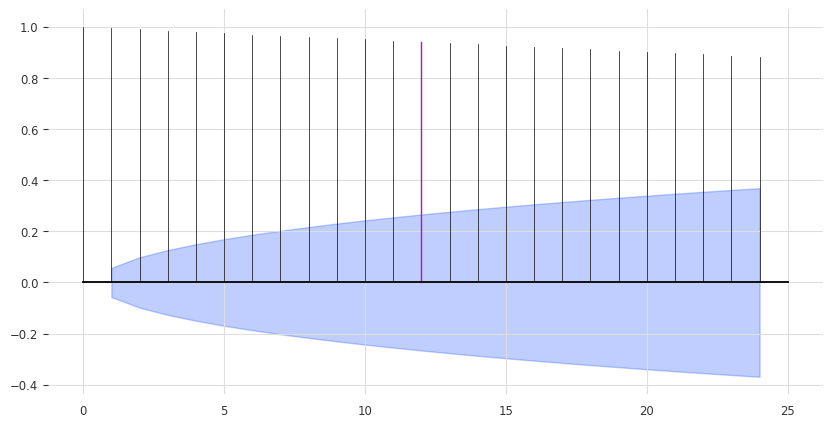

In [30]:
# PCF, seasonality test
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(ts_price, m=12, alpha=0.05)


In [31]:
for m in range(2, 25):
    is_seasonal, period = check_seasonality(ts_price, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))
    else:
        print("no seasonality and pattern")

no seasonality and pattern
no seasonality and pattern
no seasonality and pattern
no seasonality and pattern
no seasonality and pattern
no seasonality and pattern
no seasonality and pattern
no seasonality and pattern
no seasonality and pattern
no seasonality and pattern
no seasonality and pattern
no seasonality and pattern
no seasonality and pattern
no seasonality and pattern
no seasonality and pattern
no seasonality and pattern
no seasonality and pattern
no seasonality and pattern
no seasonality and pattern
no seasonality and pattern
no seasonality and pattern
no seasonality and pattern
no seasonality and pattern
